In [20]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
from fastbook import *

# Collaborative Filtering Deep Dive

## A First Look at the Data

The dataset is available through the usual fastai function:

In [23]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [24]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [25]:
import os
print(os.listdir(path))

['u3.base', 'u2.test', 'ua.test', 'u5.test', 'u.item', 'u.occupation', 'ub.test', 'u3.test', 'u.info', 'u2.base', 'u4.base', 'u.data', 'u4.test', 'u.user', 'ub.base', 'u.genre', 'u5.base', 'README', 'u1.test', 'ua.base', 'mku.sh', 'allbut.pl', 'u1.base']


In [26]:
last_skywalker = np.array([0.9, 0.8, -0.6])

Here, for instance, we are scoring *very science-fiction* as 0.98, *very action* as 0.9, and *very not old* as -0.9. We could represent a user who likes modern sci-fi action movies as:

In [27]:
user1 = np.array([0.98, 0.9, -0.9])

and we can now calculate the match between this combination:

In [28]:
(last_skywalker @ user1).sum()

2.1420000000000003

The match between this combination is:

In [30]:
(user1@casablanca).sum()

-1.9602

Since we don't know what the latent factors actually are, and we don't know how to score them for each user and movie, we should learn them.

## Learning the Latent Factors

## Creating the DataLoaders

In [31]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)

movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


We can merge this with our `ratings` table to get the user ratings by title:

In [32]:

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [33]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,7,Die Hard: With a Vengeance (1995),4
1,930,Happy Gilmore (1996),3
2,279,Kolya (1996),3
3,796,Star Trek: The Motion Picture (1979),4
4,663,Everyone Says I Love You (1996),1
5,514,Guantanamera (1994),4
6,687,Playing God (1997),2
7,807,"Shaggy Dog, The (1959)",2
8,23,Pulp Fiction (1994),4
9,312,"Godfather: Part II, The (1974)",5


To represent collaborative filtering in PyTorch we can't just use the crosstab
representation directly, especially if we want it to fit into our deep learning framework. We can represent our movie and user latent factor tables as simple matrices:

In [34]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [35]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [36]:
one_hot_3 = one_hot(3, n_users).float()

In [37]:
user_factors.t() @ one_hot_3

tensor([-0.3575, -0.2008, -0.9530, -0.2988,  1.9472])

It gives us the same vector as the one at index 3 in the matrix:

In [39]:
user_factors[3]

tensor([-0.3575, -0.2008, -0.9530, -0.2988,  1.9472])

## Collaborative Filtering from Scratch

In [46]:
class Example:
  def __init__(self, a, b):
    self.a = a
    self.b = b
  def say(self,x):
    return f'Hi {self.a}, Im {self.b}. {x}'

In [47]:
ex = Example('Steve Jobs','Suki')
ex.say('Im also going to change the world.')

'Hi Steve Jobs, Im Suki. Im also going to change the world.'

In [48]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
      self.user_factors = Embedding(n_users, n_factors)
      self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
      users = self.user_factors(x[:,0])
      movies = self.movie_factors(x[:,1])
      return (users * movies).sum(dim=1)

In [49]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [50]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

We are now ready to fit our model:

In [51]:

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.291981,1.332165,00:10
1,1.034526,1.140755,00:09
2,0.901638,1.015116,00:09
3,0.822698,0.919213,00:10
4,0.786894,0.896205,00:10


In [54]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors=Embedding(n_users, n_factors)
    self.movie_factors=Embedding(n_movies,n_factors)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), * self.y_range)

In [55]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.937947,0.999119,00:11
1,0.666911,0.959108,00:10
2,0.443943,0.951318,00:09
3,0.368489,0.953285,00:09
4,0.361663,0.952192,00:10


epoch,train_loss,valid_loss,time
0,0.942948,1.006269,00:09
1,0.662163,0.947244,00:09
2,0.467211,0.958982,00:10
3,0.359086,0.961174,00:10
4,0.361165,0.960241,00:09


In [61]:

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
      self.user_factors = Embedding(n_users, n_factors)
      self.user_bias = Embedding(n_users, 1)
      self.movie_factors = Embedding(n_movies, n_factors)
      self.movie_bias = Embedding(n_movies, 1)
      self.y_range = y_range

    def forward(self, x):
      users =self.user_factors(x[:,0])
      movies =self.movie_factors(x[:,1])
      res = (users * movies).sum(dim=1, keepdim=True)
      res += (self.user_bias(x[:,0]) + self.movie_bias(x[:,1]))
      return sigmoid_range(res, *self.y_range)

Let's try training this and see how it goes:

In [62]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.874392,0.959010,00:11
1,0.591875,0.913328,00:10
2,0.423508,0.936926,00:10
3,0.329129,0.941210,00:11
4,0.305332,0.942662,00:11


epoch,train_loss,valid_loss,time
0,0.896467,0.947172,00:11
1,0.590023,0.924513,00:11
2,0.392593,0.939082,00:12
3,0.324888,0.954453,00:10
4,0.289979,0.955660,00:11


### Weight Decay

In [63]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.890142,0.951022,00:11
1,0.672440,0.895516,00:11
2,0.507778,0.872852,00:11
3,0.447306,0.855497,00:10
4,0.431208,0.851413,00:12


Much better!

### Creating Our Own Embedding Module

In [64]:
class T(Module):
  def __init__(self):
    self.a = torch.ones(3)

L(T().parameters())

(#0) []

In [65]:
class T(Module):
  def __init__(self):
    self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

In [68]:
class T(Module):
  def __init__(self):
    self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[ 0.3702],
        [ 0.6011],
        [-0.3604]], requires_grad=True)]

In [69]:
type(t.a.weight)

torch.nn.parameter.Parameter

We can create a tensor as a parameter, with random initialization, like so:

In [70]:

def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Let's use this to create `DotProductBias` again, but without `Embedding`:

In [78]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[x:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[x:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, * self.y_range)

Then let's train it again to check we get around the same results we saw in the previous section:

In [79]:
model = DotProductBias(n_users,n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.879245,0.961243,00:11
1,0.670670,0.894430,00:10
2,0.527011,0.869047,00:10
3,0.441540,0.854131,00:11
4,0.434289,0.849885,00:11


Now, let's take a look at what our model has learned.

## Interpreting Embeddings and Biases

In [80]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Crow: City of Angels, The (1996)',
 'Jury Duty (1995)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Halloween: The Curse of Michael Myers (1995)']

In [86]:
idxs = movie_bias.argsort(descending=True)[:20]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'L.A. Confidential (1997)',
 'Titanic (1997)',
 'Star Wars (1977)',
 'As Good As It Gets (1997)',
 'Rear Window (1954)',
 'Good Will Hunting (1997)',
 'Silence of the Lambs, The (1991)',
 "Schindler's List (1993)",
 'To Kill a Mockingbird (1962)',
 'Usual Suspects, The (1995)',
 'Blade Runner (1982)',
 'Apt Pupil (1998)',
 'Close Shave, A (1995)',
 'Fugitive, The (1993)',
 'Vertigo (1958)',
 'North by Northwest (1959)',
 'Return of the Jedi (1983)',
 'Apollo 13 (1995)',
 'Godfather: Part II, The (1974)']

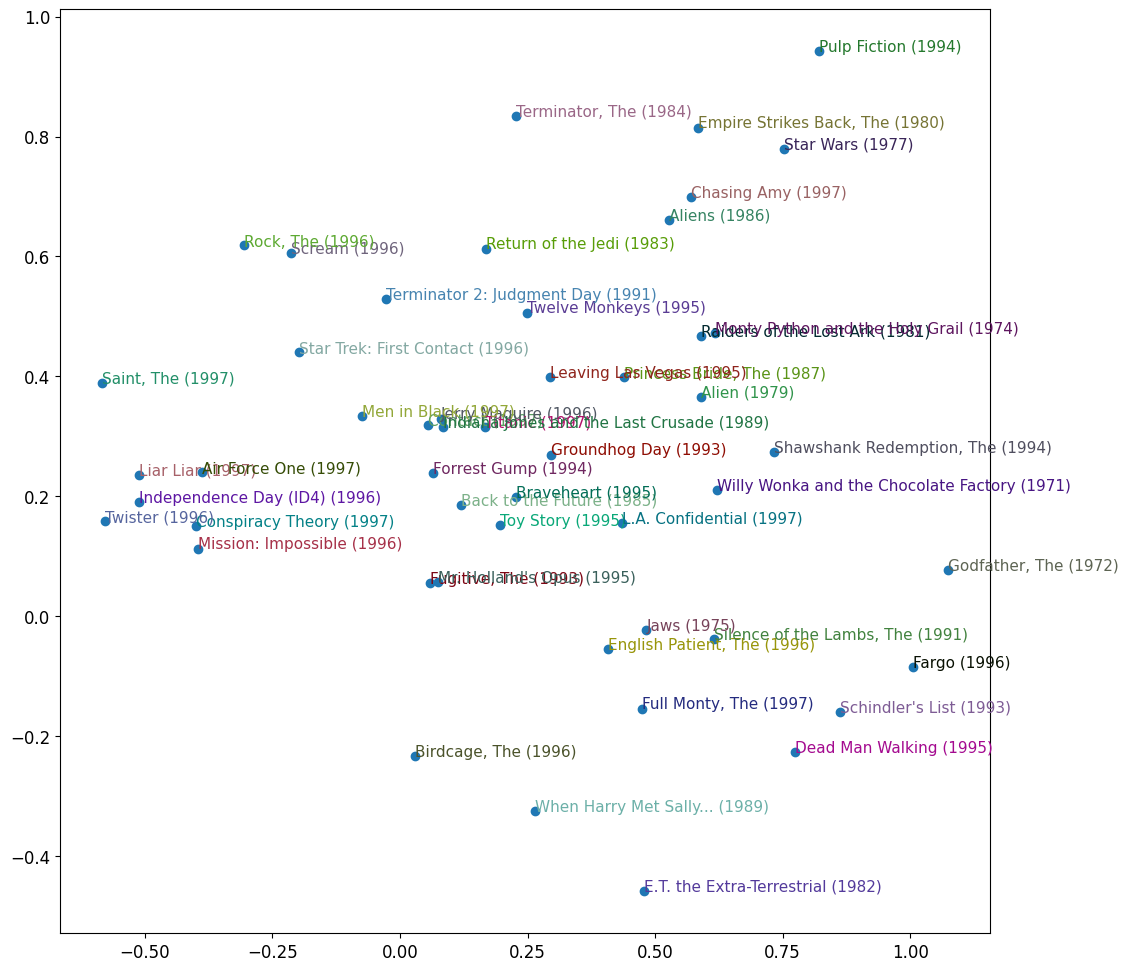

In [87]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Using fastai.collab

We can create and train a collaborative filtering model using the exact structure shown earlier by using fastai's `collab_learner`:

In [88]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [89]:

learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.913172,0.957213,00:12
1,0.696509,0.903724,00:11
2,0.519398,0.876604,00:11
3,0.449546,0.860833,00:11
4,0.415430,0.857015,00:10


The names of the layers can be seen by printing the model:

In [90]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can use these to replicate any of the analyses we did in the previous section—for instance:

In [91]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Star Wars (1977)',
 "Schindler's List (1993)",
 'Rear Window (1954)',
 'Blade Runner (1982)']

Another interesting thing we can do with these learned embeddings is to look at _distance_.

### Embedding Distance

In [94]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Interstellar (2014)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Swiss Family Robinson (1960)'

Now that we have succesfully trained a model, let's see how to deal with the situation where we have no data for a user. How can we make recommendations to new users?

## Deep Learning for Collaborative Filtering

In [95]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

Let's implement this class:

In [98]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1],n_act),
        nn.ReLU(),
        nn.Linear(n_act,1))
    self.y_range = y_range

  def forward(self,x):
    embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs,dim=1))
    return sigmoid_range(x, *self.y_range)

And use it to create a model:

In [99]:
model = CollabNN(*embs)

In [100]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.947842,0.967989,00:13
1,0.882111,0.914981,00:13
2,0.841299,0.892056,00:13
3,0.755436,0.882543,00:16
4,0.732428,0.879579,00:24


fastai provides this model in `fastai.collab` if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), and it lets you easily create more layers. For instance, here we're creating two hidden layers, of size 100 and 50, respectively:

In [101]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.928571,1.014464,00:15
1,0.893762,0.937828,00:16
2,0.818688,0.909550,00:15
3,0.755422,0.883448,00:15
4,0.733118,0.880829,00:16


`learn.model` is an object of type `EmbeddingNN`. Let's take a look at fastai's code for this class:

In [102]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

## Conclusion

For our first non-computer vision application, we looked at recommendation systems and saw how gradient descent can learn intrinsic factors or biases about items from a history of ratings. Those can then give us information about the data.

We also built our first model in PyTorch. We will do a lot more of this in the next section of the book, but first, let's finish our dive into the other general applications of deep learning, continuing with tabular data.

## Questionnaire

1. What problem does collaborative filtering solve?
1. How does it solve it?
1. Why might a collaborative filtering predictive model fail to be a very useful recommendation system?
1. What does a crosstab representation of collaborative filtering data look like?
1. Write the code to create a crosstab representation of the MovieLens data (you might need to do some web searching!).
1. What is a latent factor? Why is it "latent"?
1. What is a dot product? Calculate a dot product manually using pure Python with lists.
1. What does `pandas.DataFrame.merge` do?
1. What is an embedding matrix?
1. What is the relationship between an embedding and a matrix of one-hot-encoded vectors?
1. Why do we need `Embedding` if we could use one-hot-encoded vectors for the same thing?
1. What does an embedding contain before we start training (assuming we're not using a pretained model)?
1. Create a class (without peeking, if possible!) and use it.
1. What does `x[:,0]` return?
1. Rewrite the `DotProduct` class (without peeking, if possible!) and train a model with it.
1. What is a good loss function to use for MovieLens? Why?
1. What would happen if we used cross-entropy loss with MovieLens? How would we need to change the model?
1. What is the use of bias in a dot product model?
1. What is another name for weight decay?
1. Write the equation for weight decay (without peeking!).
1. Write the equation for the gradient of weight decay. Why does it help reduce weights?
1. Why does reducing weights lead to better generalization?
1. What does `argsort` do in PyTorch?
1. Does sorting the movie biases give the same result as averaging overall movie ratings by movie? Why/why not?
1. How do you print the names and details of the layers in a model?
1. What is the "bootstrapping problem" in collaborative filtering?
1. How could you deal with the bootstrapping problem for new users? For new movies?
1. How can feedback loops impact collaborative filtering systems?
1. When using a neural network in collaborative filtering, why can we have different numbers of factors for movies and users?
1. Why is there an `nn.Sequential` in the `CollabNN` model?
1. What kind of model should we use if we want to add metadata about users and items, or information such as date and time, to a collaborative filtering model?

### Further Research

1. What's the difference between the embedding vs create_params version?
2. Where else is collaborative filtering being used?
3. What can I do with the full movie dataset?
1. Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.